In [1]:
#! pip install fredapi

In [2]:
import os
import sys
import pandas as pd
import numpy as np

# For notebooks — get the current working directory
notebook_dir = os.getcwd()
project_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
sys.path.append(project_dir)

# Then import your module
#import Utils.functions as data_viz
import Utils.file_io as file_io

from dotenv import load_dotenv
load_dotenv()

False

In [3]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, precision_recall_curve, auc, average_precision_score, roc_auc_score, log_loss
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier
from collections import Counter
import matplotlib.pyplot as plt



In [4]:
#File imports and initialization
#classifier_models = ['logistic', 'xgb', 'balanced_rf', 'easy_ensemble', 'rf']

file_path = f"{project_dir}/Notebooks/Dataset/data_features"

df_features_daily = file_io.input_csv(f"{file_path}_daily")
df_features_weekly = file_io.input_csv(f"{file_path}_weekly")
df_features_monthly = file_io.input_csv(f"{file_path}_monthly")

#recessions = pd.read_csv(f"{project_dir}/Dataset/recession_periods.csv")
#recessions = file_io.input_csv(f"{project_dir}/Dataset/recession_periods")
recessions = pd.read_csv(f"{project_dir}/Dataset/recession_periods.csv1")

dict_features = {'Daily': df_features_daily,
                 'Weekly': df_features_weekly,
                 'Monthly': df_features_monthly
} 

train_test_split = pd.to_datetime('2015-01-01')
split_at = train_test_split

export_config = {'Print Out For all models': 
                  {'save': True},
                 'Save Probability Plots as PNG': 
                  {'save': False},
                 'Export AUC Report to CSV': 
                  {'save': False}
}


DataFrame loaded from /workspaces/RecessionPredictionML/Notebooks/Dataset/data_features_daily.csv
DataFrame loaded from /workspaces/RecessionPredictionML/Notebooks/Dataset/data_features_weekly.csv
DataFrame loaded from /workspaces/RecessionPredictionML/Notebooks/Dataset/data_features_monthly.csv


# Models of Choice

In [5]:
def xgb_init(y_train):
    num_pos = sum(y_train == 1)
    num_neg = sum(y_train == 0)
    scale = num_neg / num_pos
    #print(scale)
    model = XGBClassifier(eval_metric='logloss', random_state=42, scale_pos_weight=scale)
    return model


dict_classifier_models = {'LogisticRegression': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
                          'xgb': lambda y: xgb_init(y), 
                          'BalancedRandomForestClassifier': BalancedRandomForestClassifier(n_estimators=200, random_state=42), 
                          'EasyEnsembleClassifier': EasyEnsembleClassifier(n_estimators=200, random_state=42), 
                          'RandomForestClassifier': RandomForestClassifier(class_weight='balanced', criterion='log_loss', random_state=42, n_estimators=200)
}

In [6]:

def trad_model_init(train,test,model):
    '''
    Model Initialization function
    '''
    X_train, y_train = train[0], train[1]
    X_test, y_test = test[0], test[1]

    steps = [
        ('scaler', StandardScaler()),
        ('over', SMOTE(random_state=42, sampling_strategy= 0.5)),
        ('under', RandomUnderSampler(random_state=42, sampling_strategy=1.0))
    ]

    steps1 = [('scaler', StandardScaler())]
    model_name = str(model)
    model_name = model_name.split("(")[0].lower()

    if model_name in ['logisticregression', 'xgbclassifier', 'balancedrandomforestclassifier']:
        steps.append(('classifier', model))
        pipeline = Pipeline(steps=steps)
    else:
        steps1.append(('classifier', model))
        pipeline = Pipeline(steps=steps1)

    pipeline.fit(X_train, y_train)
    #probs = pipeline.predict_proba(X_test))[:, 1]
    X_all = pd.concat([X_train, X_test])
    probs = pipeline.predict_proba(X_all)[:, 1]
    dates_all = pd.to_datetime(X_all.index)
    prob_series = pd.Series(probs, index=dates_all)

    return pipeline, prob_series

def trad_model_metrics(test, probs, threshold = None):
    '''
    Model Finalizing function
    '''
    X_test, y_test = test[0], test[1]
    #probs = pipeline.predict_proba(X_test)[:, 1]
    #probs
    if threshold is None:
        threshold = 0.001
    y_pred = (probs >= threshold).astype(int)

    precision, recall, thresholds = precision_recall_curve(y_test, probs)
    #cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=["No Recession", "Recession"], output_dict=True, zero_division=0)
    report["auc_pr"] = auc(recall, precision)
    report["ap_score"]=  average_precision_score(y_test, probs)
    report["auc_roc"]= roc_auc_score(y_test, probs)
    report["log_loss"] = log_loss(y_test, probs)

    return report



In [7]:
#Initialize models
#Get pipleines and probability values
classifier_results = {}

for time_freq, df in dict_features.items():
    X = df.drop(columns='recession')
    y = df['recession'] 

    # Train-test split
    #split_at = pd.to_datetime('2015-01-01')
    X_train, X_test = X[X.index < split_at], X[X.index >= split_at]
    y_train, y_test = y[y.index < split_at].astype(int), y[y.index >= split_at].astype(int)

    classifier_results[time_freq] = {}
    for model_name, model in dict_classifier_models.items():
        classifier_results[time_freq][model_name] = {}

        if callable(model):
            model_instance = model(y_train)
        else:
            model_instance = model

        pipeline, probs = trad_model_init([X_train, y_train],[X_test, y_test], model_instance)
        classifier_results[time_freq][model_name]['pipeline'] = pipeline 
        classifier_results[time_freq][model_name]['probs'] = probs 
 

In [8]:
# Get metrics and report from model pipelines

for time_freq, model_details in classifier_results.items():

    df = dict_features[time_freq]
    X = df.drop(columns='recession')
    y = df['recession']

    # Train-test split
    #split_at = pd.to_datetime('2015-01-01')
    X_test = X[X.index >= split_at]
    y_test = y[y.index >= split_at].astype(int)


    for model_name in dict_classifier_models.keys():
        probs = classifier_results[time_freq][model_name]['probs']
        report = trad_model_metrics(probs = probs[split_at:], test = [X_test, y_test], threshold = None)
        classifier_results[time_freq][model_name]['report'] = report
        #print(model_name)
        #print(df)
        

In [9]:

# Print out for all Reports
if export_config['Print Out For all models']['save']:
    for time_freq in classifier_results.keys():
        for model_name in classifier_results[time_freq].keys():
            print(f"\n=== {time_freq} | {model_name} ===")
            #print("Confusion Matrix:\n", classifier_results[time_freq][f'{model_name}_confusion_matrix'])
            print("Classification Report:")
            print(pd.DataFrame(classifier_results[time_freq][model_name]['report']).transpose())




=== Daily | LogisticRegression ===
Classification Report:
              precision    recall  f1-score      support
No Recession   0.000000  0.000000  0.000000  2471.000000
Recession      0.113702  1.000000  0.204187   317.000000
accuracy       0.113702  0.113702  0.113702     0.113702
macro avg      0.056851  0.500000  0.102093  2788.000000
weighted avg   0.012928  0.113702  0.023216  2788.000000
auc_pr         0.171316  0.171316  0.171316     0.171316
ap_score       0.172005  0.172005  0.172005     0.172005
auc_roc        0.722166  0.722166  0.722166     0.722166
log_loss       1.006872  1.006872  1.006872     1.006872

=== Daily | xgb ===
Classification Report:
              precision    recall  f1-score      support
No Recession   0.000000  0.000000  0.000000  2471.000000
Recession      0.113702  1.000000  0.204187   317.000000
accuracy       0.113702  0.113702  0.113702     0.113702
macro avg      0.056851  0.500000  0.102093  2788.000000
weighted avg   0.012928  0.113702  0.02321

In [10]:
# Removing underperforming models based on AUC-ROC scores
# Only models with AUC-ROC >= 0.5 are retained
# AUC-ROC of 0.5 represents random guessing, so anything below that is worse than chance

import copy

classifier_results_selective = copy.deepcopy(classifier_results)
keys = list(classifier_results_selective.keys())
for time_freq in list(classifier_results_selective.keys()):
    for model_name in list(classifier_results_selective[time_freq].keys()):
        if classifier_results_selective[time_freq][model_name]['report']['auc_roc'] < 0.5:
            del classifier_results_selective[time_freq][model_name]



# Visualizing Model Performance Using Predicted Probabilities

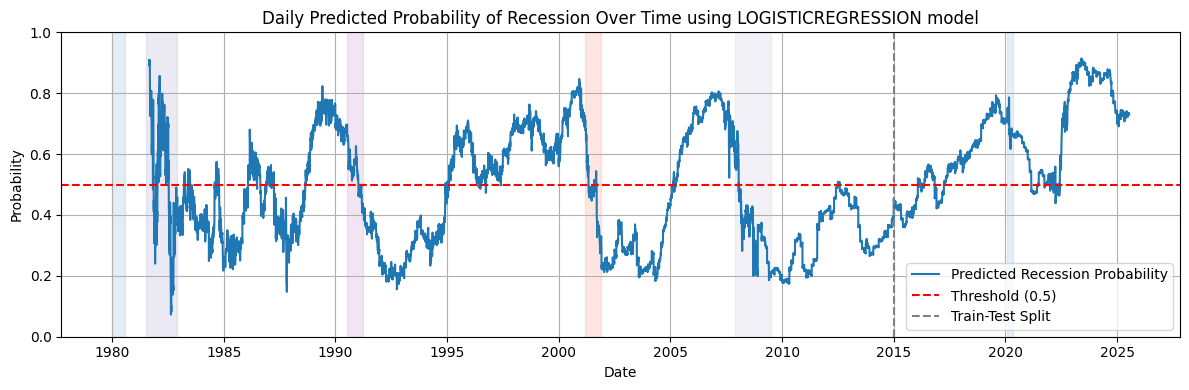

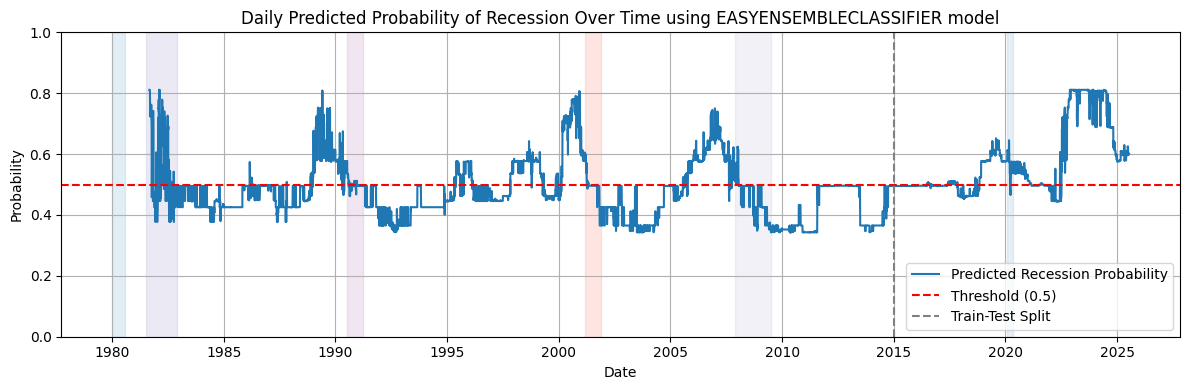

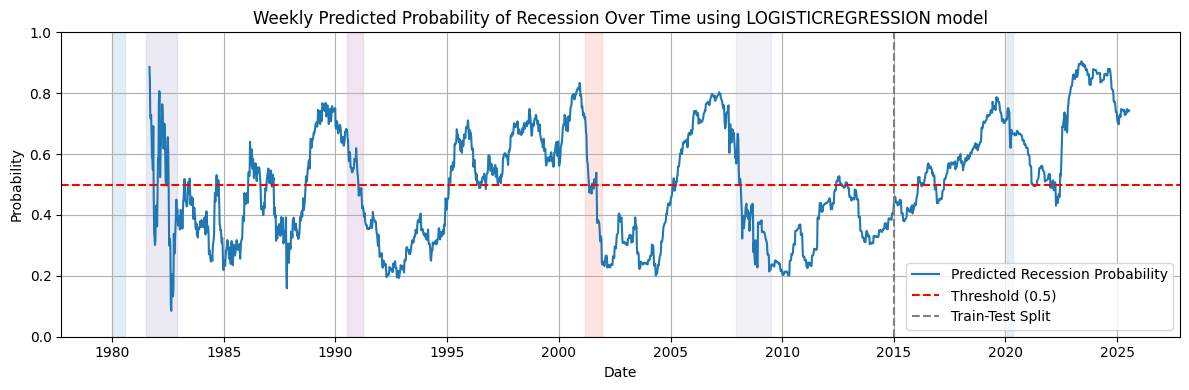

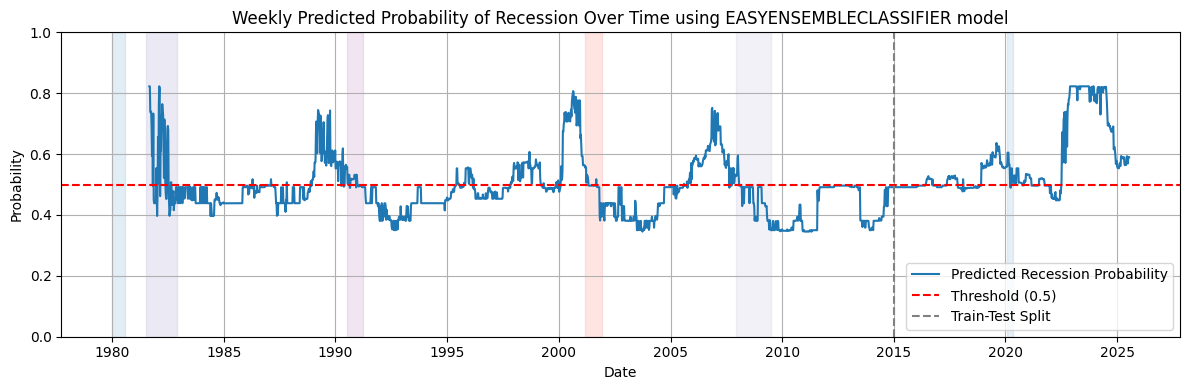

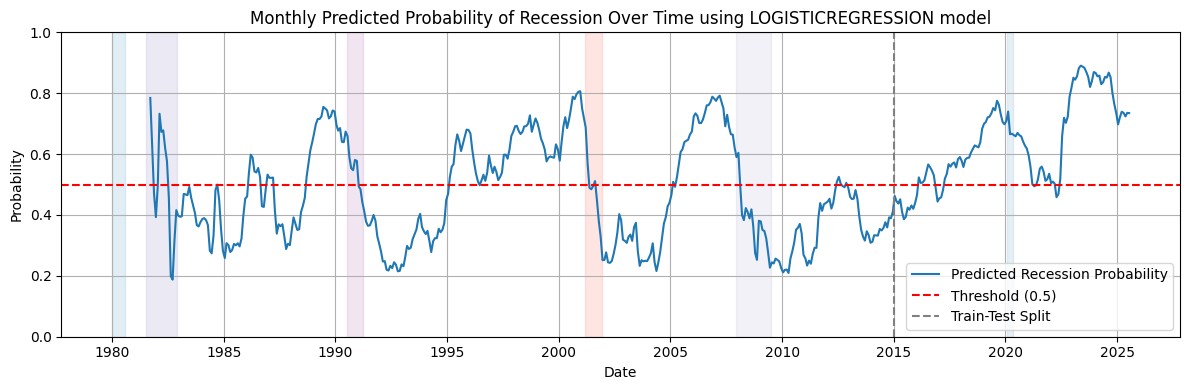

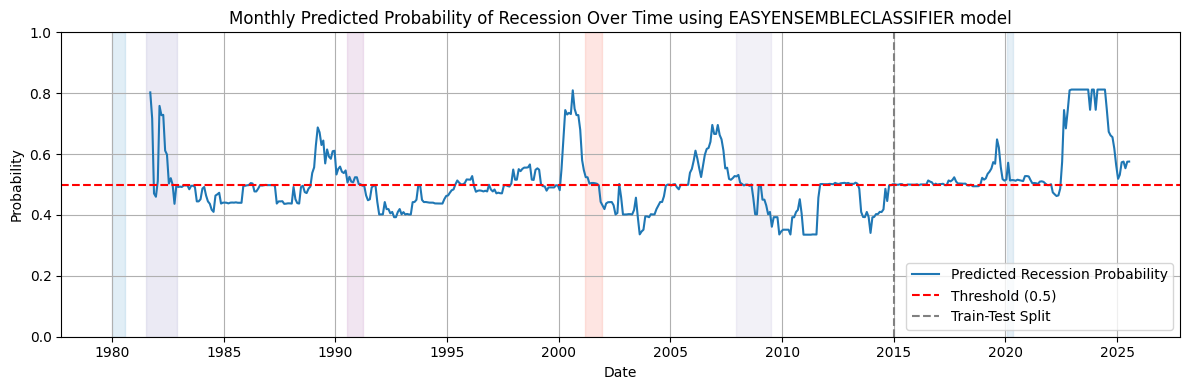

In [11]:

for time_freq, df in dict_features.items():
    #print(time_freq)
    X = df.drop(columns='recession')
    y = df['recession']
    # Train-test split
    #split_at = pd.to_datetime('2015-01-01')
    X_train, X_test = X[X.index < split_at], X[X.index >= split_at]
    y_train, y_test = y[y.index < split_at], y[y.index >= split_at]
    for model_name in classifier_results_selective[time_freq].keys():
        prob_series = classifier_results_selective[time_freq][model_name]['probs']

        # Plot
        plt.figure(figsize=(12, 4))
        plt.plot(prob_series, label='Predicted Recession Probability')
        #if model_name in ['logistic']:
        #    plt.axhline(y=0.4, color='r', linestyle='--', label='Threshold (0.4)')
        #elif model_name in ['balanced_rf','rf']:
        #    plt.axhline(y=0.85, color='r', linestyle='--', label='Threshold (0.8)')
        #else:
        plt.axhline(y=0.5, color='r', linestyle='--', label='Threshold (0.5)')
        plt.axvline(x=train_test_split, label='Train-Test Split', color='gray', linestyle='--')
#
        if recessions is not None:
            for row in recessions.itertuples(index=False):
                plt.axvspan(pd.to_datetime(row.start), pd.to_datetime(row.end), color=row.color, alpha=0.2)

        file_name = f'{time_freq} Predicted Probability of Recession Over Time using {model_name.upper()} model'
        plt.title(file_name)
        plt.xlabel('Date')
        plt.ylabel('Probability')
        #handles, labels = plt.gca().get_legend_handles_labels()
        plt.legend()#handles[:2], labels[:2], loc = 'upper left')
        plt.ylim(0, 1)
        plt.grid(True)
        plt.tight_layout()

        file_io.output_png(plt, file_name = file_name, 
                            flag = export_config['Save Probability Plots as PNG']['save'])

        plt.show()

In [12]:
# Data Collection to analyze in report

if export_config['Export AUC Report to CSV']['save']:
    from datetime import datetime
    import pytz
    import csv

    tz = pytz.timezone('US/Eastern')
    eastern_time = datetime.now(tz)
    eastern_time = eastern_time.strftime("%Y-%m-%d %H;%M;%S")
    rows = []

    for time_freq in list(classifier_results.keys()):
        for model_name in list(classifier_results[time_freq].keys()):
            auc_roc = classifier_results[time_freq][model_name]['report']['auc_roc']
            #print(auc_roc)
            rows.append([time_freq, model_name, auc_roc.round(4)])

    # Save to CSV
    with open(f"{project_dir}/Dataset/auc_roc_summary_{eastern_time}.csv1", mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['time_freq', 'model_name', 'auc_roc'])  # header
        writer.writerows(rows)
